In [30]:
import os
import shutil
import subprocess
import sys
import tempfile

import faceted
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot
import vcm
import vcm.fv3
import xarray as xr

from vcm import RegionOfInterest
import intake
from vcm.catalog import catalog

grid = catalog["grid/c48"].read()


_KG_M2S_TO_MM_DAY = (1e3 * 86400) / 997.0
fsize=14
from vcm.catalog import catalog
from dask.diagnostics import ProgressBar

sys.path.append("/home/AnnaK/explore/spencerc/2021-10-06-waves")
import spectral_analysis


def save_fig(name: str, dpi: int=150,):
    plt.savefig(f"figures/pdf/{name}.pdf", dpi=dpi, bbox_inches='tight')
    plt.savefig(f"figures/png/{name}.png", dpi=dpi, bbox_inches='tight')
    plt.savefig(f"figures/eps/{name}.eps", format="eps", bbox_inches='tight')

In [4]:
IMAGE = "us.gcr.io/vcm-ml/post_process_run:latest"


def add_fregrid_metadata(ds):
    ds["x"] = ds.x.assign_attrs({"cartesian_axis": "X"})
    ds["y"] = ds.y.assign_attrs({"cartesian_axis": "Y"})
    if "tile" in ds:
        ds = ds.drop("tile")
    return ds


def regrid(url, variable, output):
    subprocess.call(["docker", "image", "pull", IMAGE])
    ds = vcm.fv3.standardize_fv3_diagnostics(xr.open_zarr(fsspec.get_mapper(url)))
    ds = ds[[variable]]    
    ds = add_fregrid_metadata(ds)
    ds = ds.resample(time="6H").mean()

    with tempfile.TemporaryDirectory() as tmpdir:
        input_file = os.path.join(tmpdir, "data_in.nc")
        output_file = os.path.join(tmpdir, "data.nc")        
        docker_in = "/tmp/data_in.nc"
        docker_out = "/tmp/data.nc"

        with ProgressBar():
            ds.to_netcdf(input_file)

        call = [
            "docker",
            "run",
            "-v",
            f"{input_file}:{docker_in}",
            "-v",
            f"{tmpdir}:{docker_out}",
            IMAGE,
            "fregrid_single_input",
            docker_in,
            docker_out,
        ]
        result = subprocess.check_output(call)
        shutil.copyfile(output_file, output)
        return result.decode()

In [5]:
BASELINE_URL = "gs://vcm-ml-experiments/claytons/2022-08-10/baseline-trial2/fv3gfs_run/diags.zarr"
stdout = regrid(BASELINE_URL, "total_precipitation_rate", os.path.abspath("baseline-precip-6hr.nc"))

[########################################] | 100% Completed | 11.2s


In [6]:
UNPERTURBED_FINE_RES = "gs://vcm-ml-intermediate/2021-10-12-PIRE-c48-post-spinup-verification/pire_atmos_phys_3h_coarse.zarr"
stdout = regrid(UNPERTURBED_FINE_RES, "PRATEsfc", os.path.abspath("fine-res-precip-6hr.nc"))

[########################################] | 100% Completed |  6.8s


In [7]:
ML_TQUV_URL = "gs://vcm-ml-experiments/out-of-sample-right-side-up-winds/2023-01-25/ml-tapered-all-tquv-seed-0/fv3gfs_run/diags.zarr"
stdout = regrid(ML_TQUV_URL, "total_precipitation_rate", os.path.abspath("ml-tquv-precip-6hr.nc"))

[########################################] | 100% Completed | 11.3s


In [8]:
ML_TQUV_OCSVM_TQ_URL = "gs://vcm-ml-experiments/out-of-sample-right-side-up-winds/2023-01-24/oos-tapered-tquv-nd-ocsvm-tq-0-default-0-trial0/fv3gfs_run/diags.zarr"
stdout = regrid(ML_TQUV_OCSVM_TQ_URL, "total_precipitation_rate", os.path.abspath("ml-tquv-ocsvm-tq-precip-6hr.nc"))

[########################################] | 100% Completed | 11.0s


In [9]:
datasets = {
    "baseline-precip-6hr.nc": "total_precipitation_rate", 
    "ml-tquv-precip-6hr": "total_precipitation_rate",
    "ml-tquv-ocsvm-tq-precip-6hr": "total_precipitation_rate",
    "fine-res-precip-6hr.nc": "PRATEsfc",
}

In [10]:
def tropical_mean(da):
    deep_tropics = da.sel(latitude=slice(-15, 15))
    return deep_tropics.weighted(np.cos(np.deg2rad(deep_tropics.latitude))).mean("latitude")

In [84]:


data = {
    "Baseline": xr.open_dataset("baseline-precip-6hr.nc").total_precipitation_rate,
    "$g_\mathrm{Tquv}$": xr.open_dataset("ml-tquv-precip-6hr.nc").total_precipitation_rate,
    "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$": xr.open_dataset("ml-tquv-ocsvm-tq-precip-6hr.nc").total_precipitation_rate,
    "Fine-grid reference": xr.open_dataset("fine-res-precip-6hr.nc").PRATEsfc
}
means = {dataset: 86400 * tropical_mean(data[dataset]).compute() for dataset in data}

In [13]:
common_times = sorted(list(
    set(means["baseline"].time.values)
    .intersection(means["ml-tquv"].time.values)
    .intersection(means["ml-tquv-ocsvm-tq"].time.values)
    .intersection(means["fine-res"].time.values)
))
common_time_coords =  [vcm.cast_to_datetime(t) for t in common_times]

In [83]:
fig, (ax1, ax2, ax3, ax4), cax = faceted.faceted(1, 4, aspect=4., width=8, cbar_mode="single", cbar_location="bottom", cbar_pad=0.5)

c = means["fine-res"] \
    .sel(time=common_times) \
    .assign_coords(time=common_time_coords) \
    .plot(ax=ax1, y="time", add_colorbar=False, vmin=0, vmax=20, cmap="Blues", rasterized=True)

means["baseline"] \
    .sel(time=common_times) \
    .assign_coords(time=common_time_coords) \
    .plot(ax=ax2, y="time", add_colorbar=False, vmin=0, vmax=20, cmap="Blues",rasterized=True)

means["ml-tquv"] \
    .sel(time=common_times) \
    .assign_coords(time=common_time_coords) \
    .plot(ax=ax3, y="time", add_colorbar=False, vmin=0, vmax=20, cmap="Blues",rasterized=True)

means["ml-tquv-ocsvm-tq"] \
    .sel(time=common_times) \
    .assign_coords(time=common_time_coords) \
    .plot(ax=ax4, y="time", add_colorbar=False, vmin=0, vmax=20, cmap="Blues",rasterized=True)


ax1.set_title("Fine-grid")
ax2.set_title("Baseline")
ax3.set_title("ML-Tquv")
ax4.set_title("ML-Tquv-OCSVM-Tq")

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Longitude [degrees]")
    ax.set_ylabel("")
    
plt.colorbar(c, cax=cax, orientation="horizontal", label=u"Precipitation rate (6 hour average) \n between 15°S and 15°N [mm/day]")
save_fig('prognostic_precip_tropics_hovmollers')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



Traceback (most recent call last):
  File "/home/AnnaK/miniconda3/envs/fv3net/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-83-9fa27ff55ecb>", line 34, in <module>
    save_fig('prognostic_precip_tropics_hovmollers')
  File "<ipython-input-30-e440a9907f3a>", line 36, in save_fig
    plt.savefig(f"figures/eps/{name}.eps", format="eps", bbox_inches='tight')
  File "/home/AnnaK/.local/lib/python3.8/site-packages/matplotlib/pyplot.py", line 723, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/home/AnnaK/.local/lib/python3.8/site-packages/matplotlib/figure.py", line 2203, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/home/AnnaK/.local/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 2119, in print_figure
    result = print_method(
  File "/home/AnnaK/.local/lib/python3.8/site-packages/matplotlib/backends/backend_ps.py", line 831, i

KeyboardInterrupt: 

#### Precip PDF

In [97]:
from cycler import cycler
import matplotlib as mpl
import fv3viz
fv3viz.use_colorblind_friendly_style()

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

colorlist = ['black']  + default_colors # [default_colors[-5], 'black', ] + default_colors
colorlist = ['black']  + ['#56B4E9', '#0072B2','#009E73', '#E69F00'] #default_colors[0],]

cmap = mpl.colors.ListedColormap(colorlist)
custom_cycler = cycler(color=cmap.colors,) #or simply color=colorlist

In [91]:

grid = catalog["grid/c48"].read()


baseline_precip = intake.open_zarr("gs://vcm-ml-experiments/claytons/2022-08-10/baseline-trial2/fv3gfs_run/diags.zarr").to_dask() \
    .resample(time="1D").mean()["total_precipitation_rate"]

verif_precip = catalog["2020_1yr_pire_physics"].to_dask() \
    .resample(time="1D").mean() \
    .rename({"PRATEsfc_coarse": "total_precipitation_rate"})["total_precipitation_rate"] \
    .rename({"grid_xt": "x", "grid_yt": "y"})

ml_tq_precip = intake.open_zarr("gs://vcm-ml-experiments/out-of-sample-right-side-up-winds/2023-03-06/ml-tapered-all-tq-seed-0/fv3gfs_run/diags.zarr").to_dask() \
    .resample(time="1D").mean()["total_precipitation_rate"]
ml_tquv_precip = intake.open_zarr("gs://vcm-ml-experiments/out-of-sample-right-side-up-winds/2023-01-25/ml-tapered-all-tquv-seed-0/fv3gfs_run/diags.zarr").to_dask() \
    .resample(time="1D").mean()["total_precipitation_rate"]
ml_tquv_ocsvm_tq_precip = intake.open_zarr("gs://vcm-ml-experiments/out-of-sample-right-side-up-winds/2023-01-24/oos-tapered-tquv-nd-ocsvm-tq-0-default-0-trial0/fv3gfs_run/diags.zarr").to_dask() \
    .resample(time="1D").mean()["total_precipitation_rate"]

In [92]:

varname="total_precipitation_rate"
histograms = {}
for ds_, label in zip(
    [verif_precip, baseline_precip, ml_tq_precip, ml_tquv_precip, ml_tquv_ocsvm_tq_precip], 
    ["Fine-grid reference", "Baseline","$g_\mathrm{Tq}$", "$g_\mathrm{Tquv}$", "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]
):
    counts = xr.Dataset()
    count, width = vcm.histogram(
        ds_  * _KG_M2S_TO_MM_DAY, bins= np.logspace(-1, np.log10(500), 101), density=True
    )
    counts[varname] = count
    counts[f"{varname}_bin_width"] = width
    histograms[label] = counts

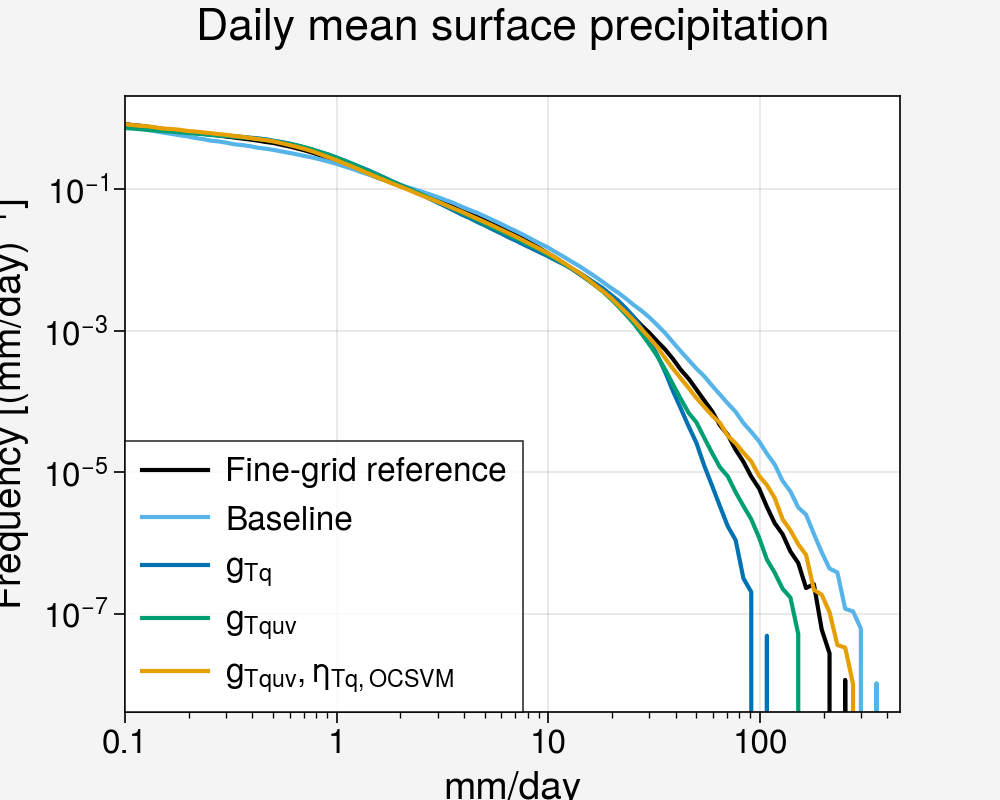

In [101]:
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(5,4))
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

for label, hist in histograms.items():
    hist["total_precipitation_rate"].plot(label=label)


plt.xlim(hist.total_precipitation_rate_bins.min(), hist.total_precipitation_rate_bins.max())
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')

plt.tick_params(axis='both', labelsize=12, )

ax.yaxis.set_major_formatter(proplot.Formatter('log'))
#ax.yaxis.get_major_formatter().set_scientific(True)

plt.title("Daily mean surface precipitation", fontsize=fsize+2, pad=20)
    
plt.xlabel("mm/day", fontsize=fsize)
plt.ylabel('Frequency [(mm/day)$^{-1}$]', fontsize=fsize)
save_fig('precip_pdf_global')

In [94]:
varname="total_precipitation_rate"
histograms_tropics = {}
for ds_, label in zip(
    [verif_precip, baseline_precip, ml_tq_precip, ml_tquv_precip, ml_tquv_ocsvm_tq_precip], 
    ["Fine-grid reference", "Baseline","$g_\mathrm{Tq}$", "$g_\mathrm{Tquv}$", "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]
):
    counts = xr.Dataset()
    count, width = vcm.histogram(
        ds_.where(grid.lat < 15).where(grid.lat>-15)  * _KG_M2S_TO_MM_DAY, bins= np.logspace(-1, np.log10(500), 101), density=True
    )

    counts[varname] = count
    counts[f"{varname}_bin_width"] = width
    histograms_tropics[label] = counts


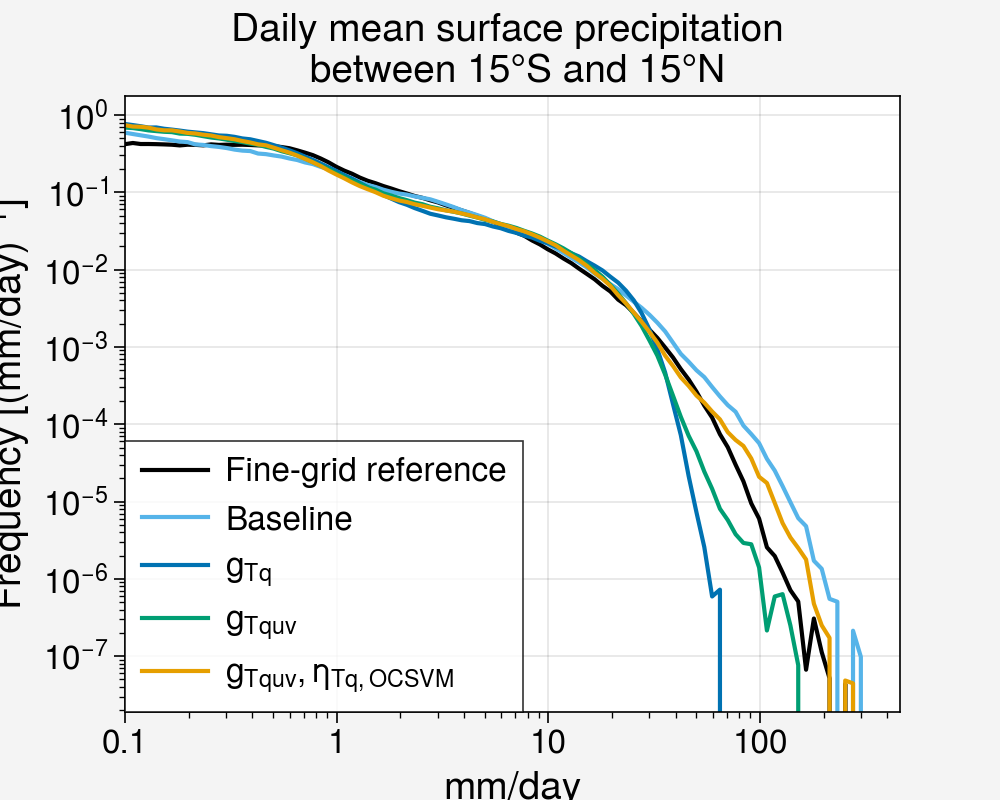

In [100]:
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(5,4))
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

for label, hist in histograms_tropics.items():
    hist["total_precipitation_rate"].plot(label=label)


plt.xlim(hist.total_precipitation_rate_bins.min(), hist.total_precipitation_rate_bins.max())
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')

plt.tick_params(axis='both', labelsize=12, )

ax.yaxis.set_major_formatter(proplot.Formatter('log'))
#ax.yaxis.get_major_formatter().set_scientific(True)

plt.title("Daily mean surface precipitation \n between 15°S and 15°N", fontsize=fsize)
    
plt.xlabel("mm/day", fontsize=fsize)
plt.ylabel('Frequency [(mm/day)$^{-1}$]', fontsize=fsize)
save_fig('precip_pdf_tropic')